<a href="https://colab.research.google.com/github/Ayushraj6942/GDG-Project/blob/main/gdg_last_ass_prob2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 Segment Tree for Range Minimum Query (RMQ) and Maximum Query

In [ ]:
class SegmentTree:
    def __init__(self, data):
        self.n = len(data)
        self.tree_min = [0] * (4 * self.n)
        self.tree_max = [0] * (4 * self.n)
        self.build(data, 0, 0, self.n - 1)

    def build(self, data, node, start, end):
        if start == end:
            self.tree_min[node] = data[start]
            self.tree_max[node] = data[start]
        else:
            mid = (start + end) // 2
            left_child = 2 * node + 1
            right_child = 2 * node + 2
            self.build(data, left_child, start, mid)
            self.build(data, right_child, mid + 1, end)
            self.tree_min[node] = min(self.tree_min[left_child], self.tree_min[right_child])
            self.tree_max[node] = max(self.tree_max[left_child], self.tree_max[right_child])

    def range_query(self, node, start, end, L, R, find_min=True):
        if R < start or L > end:  # No overlap
            return float('inf') if find_min else float('-inf')
        if L <= start and end <= R:  # Total overlap
            return self.tree_min[node] if find_min else self.tree_max[node]
        # Partial overlap
        mid = (start + end) // 2
        left_res = self.range_query(2 * node + 1, start, mid, L, R, find_min)
        right_res = self.range_query(2 * node + 2, mid + 1, end, L, R, find_min)
        return min(left_res, right_res) if find_min else max(left_res, right_res)

    def query_min(self, L, R):
        return self.range_query(0, 0, self.n - 1, L, R, find_min=True)

    def query_max(self, L, R):
        return self.range_query(0, 0, self.n - 1, L, R, find_min=False)

    def update(self, index, value, node=0, start=0, end=None):
        if end is None:
            end = self.n - 1
        if start == end:
            self.tree_min[node] = value
            self.tree_max[node] = value
        else:
            mid = (start + end) // 2
            left_child = 2 * node + 1
            right_child = 2 * node + 2
            if index <= mid:
                self.update(index, value, left_child, start, mid)
            else:
                self.update(index, value, right_child, mid + 1, end)
            self.tree_min[node] = min(self.tree_min[left_child], self.tree_min[right_child])
            self.tree_max[node] = max(self.tree_max[left_child], self.tree_max[right_child])

    def append(self, value):
        self.n += 1
        self.tree_min.append(value)
        self.tree_max.append(value)
        self.update(self.n - 1, value)

# Example usage
prices = [100, 102, 98, 105, 110, 95]
seg_tree = SegmentTree(prices)
print("Min in range [1, 4]:", seg_tree.query_min(1, 4))
print("Max in range [1, 4]:", seg_tree.query_max(1, 4))


Min in range [1, 4]: 98
Max in range [1, 4]: 110


Fetching BTC-USD Data

In [ ]:
import yfinance as yf
import pandas as pd

# Fetch BTC-USD historical data
btc_data = yf.download('BTC-USD', start="2024-01-01", end="2024-03-01", interval="1d", auto_adjust=True)

# Debug: Check column names
print("Columns in DataFrame:", btc_data.columns)

# Fix: Access 'Close' column with MultiIndex
if ('Close', 'BTC-USD') in btc_data.columns:
    prices = btc_data[('Close', 'BTC-USD')].tolist()  # Correct MultiIndex access
    print("Sample Prices:", prices[:5])  # Print first 5 prices
else:
    raise ValueError("Column 'Close' not found in downloaded data.")

# Save to CSV for further processing
btc_data.to_csv('btc_prices.csv')


[*********************100%***********************]  1 of 1 completed

Columns in DataFrame: MultiIndex([( 'Close', 'BTC-USD'),
            (  'High', 'BTC-USD'),
            (   'Low', 'BTC-USD'),
            (  'Open', 'BTC-USD'),
            ('Volume', 'BTC-USD')],
           names=['Price', 'Ticker'])
Sample Prices: [44167.33203125, 44957.96875, 42848.17578125, 44179.921875, 44162.69140625]


Trading Strategy & Analysis

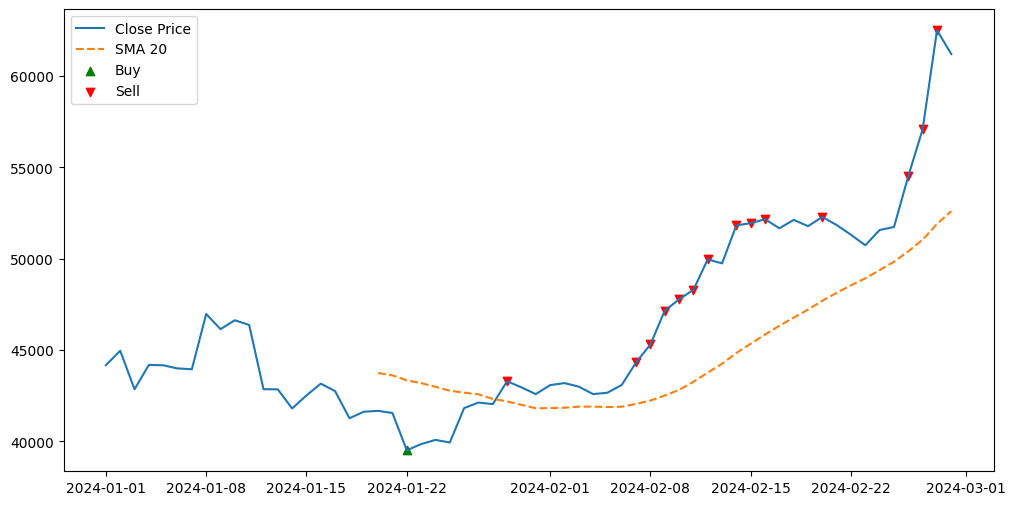

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Ensure SMA is calculated
btc_data['SMA_20'] = btc_data[('Close', 'BTC-USD')].rolling(window=20).mean()

# Detect support & resistance levels using the Segment Tree
seg_tree = SegmentTree(prices)

# Convert support & resistance to Pandas Series aligned with btc_data index
supports = pd.Series([seg_tree.query_min(max(0, i - 10), i) for i in range(len(prices))], index=btc_data.index)
resistances = pd.Series([seg_tree.query_max(max(0, i - 10), i) for i in range(len(prices))], index=btc_data.index)

# Assign aligned values to the DataFrame
btc_data['Support'] = supports
btc_data['Resistance'] = resistances

# Generate buy/sell signals with aligned indices
btc_data['Buy_Signal'] = (btc_data[('Close', 'BTC-USD')] <= btc_data['Support']) & (btc_data[('Close', 'BTC-USD')] < btc_data['SMA_20'])
btc_data['Sell_Signal'] = (btc_data[('Close', 'BTC-USD')] >= btc_data['Resistance']) & (btc_data[('Close', 'BTC-USD')] > btc_data['SMA_20'])

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(btc_data.index, btc_data[('Close', 'BTC-USD')], label="Close Price")
plt.plot(btc_data.index, btc_data['SMA_20'], label="SMA 20", linestyle="dashed")
plt.scatter(btc_data.index[btc_data['Buy_Signal']], btc_data[('Close', 'BTC-USD')][btc_data['Buy_Signal']], label="Buy", color='green', marker='^')
plt.scatter(btc_data.index[btc_data['Sell_Signal']], btc_data[('Close', 'BTC-USD')][btc_data['Sell_Signal']], label="Sell", color='red', marker='v')
plt.legend()
plt.show()
